In [60]:
import caiman as cm
import glob
import gc
import numpy as np
import matplotlib.pyplot as plt
from caiman.source_extraction.cnmf.cnmf import load_CNMF
from pathlib import Path
import pickle
import mesmerize_core as ms


In [66]:
data_path = Path("/scratch/dspalla/2p_data/429420_toms/20230210")

# Visualize raw and mcorr video

In [69]:
#tif_file = glob.glob(str(data_path)+'/*.tif')[0]
cropped_file = glob.glob(str(data_path)+'/cropped*.mmap')[0]
mcorr_file = glob.glob(str(data_path)+'/mcorr*.mmap')[0]
#print(tif_file)
print(cropped_file)
print(mcorr_file)

/scratch/dspalla/2p_data/429420_toms/20230210/cropped_d1_490_d2_490_d3_1_order_F_frames_94725.mmap
/scratch/dspalla/2p_data/429420_toms/20230210/mcorr_d1_490_d2_490_d3_1_order_F_frames_94725.mmap


In [70]:
#input_movie = cm.load(tif_file)

cropped_movie = cm.load(cropped_file)
mcorr_movie = cm.load(mcorr_file)


Decode mmap filename /scratch/dspalla/2p_data/429420_toms/20230210/cropped_d1_490_d2_490_d3_1_order_F_frames_94725.mmap
Decode mmap filename /scratch/dspalla/2p_data/429420_toms/20230210/mcorr_d1_490_d2_490_d3_1_order_F_frames_94725.mmap


In [72]:
# make an image widget
from fastplotlib import ImageWidget, Plot, GridPlot
from ipywidgets import VBox, IntSlider, Layout

movies = [cropped_movie,mcorr_movie]

iw = ImageWidget(
    movies, 
    window_funcs={"t": (np.mean, 100)},
    vmin_vmax_sliders=True,
    cmap="jet"
)

iw.show()

RFBOutputContext()

In [73]:
iw.plot.canvas.close()

# Raw video metrics

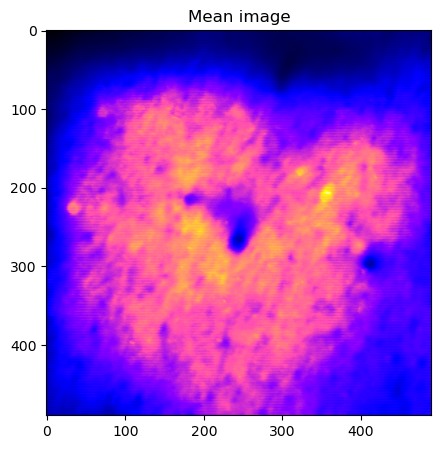

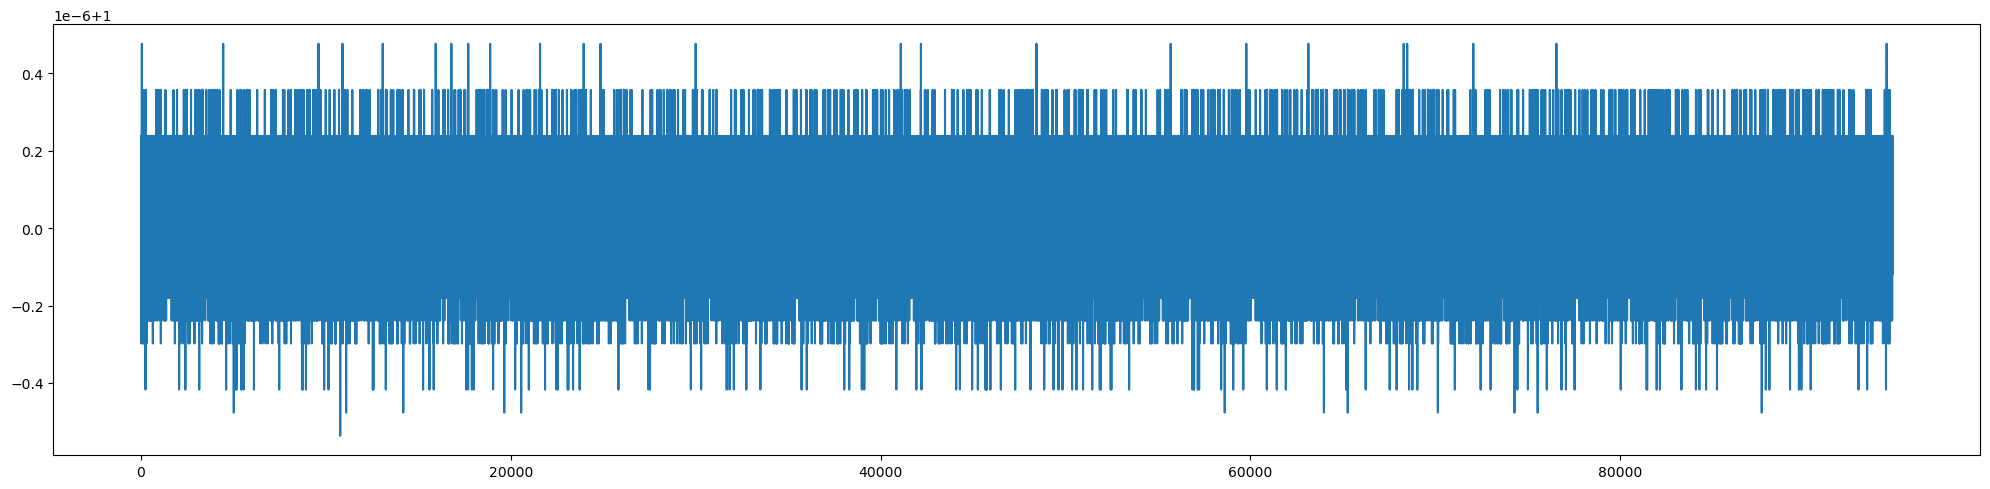

In [75]:
metrics_file = data_path.joinpath('raw_metrics.pickle')
with open(metrics_file,'rb') as file:
    metrics = pickle.load(file)


plt.figure(figsize=(5,5))
plt.title('Mean image')
plt.imshow(metrics['mean_image'],cmap=plt.cm.gnuplot2)

plt.figure(figsize=(20,5))
plt.plot(metrics['frame_average'])
#plt.ylim([0.9,1.1])


plt.tight_layout()

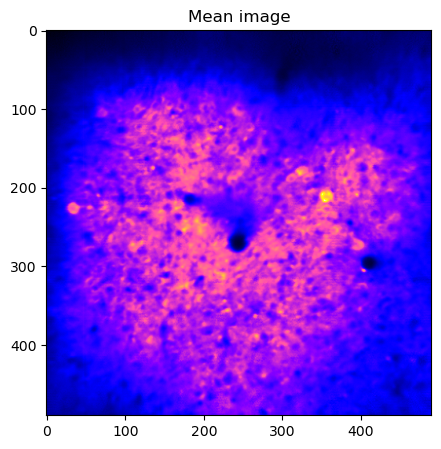

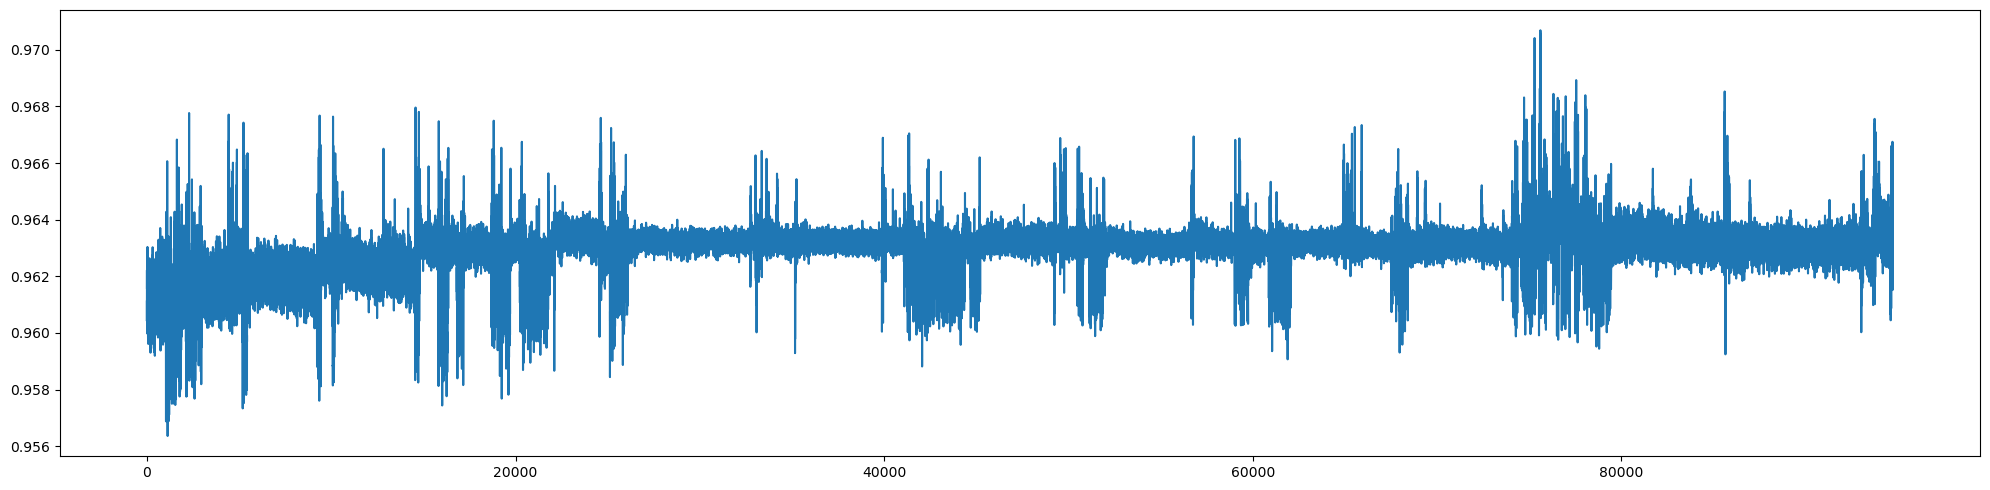

In [76]:
metrics_file = data_path.joinpath('mcorr_metrics.pickle')
with open(metrics_file,'rb') as file:
    metrics = pickle.load(file)


plt.figure(figsize=(5,5))
plt.title('Mean image')
plt.imshow(metrics['mean_image'],cmap=plt.cm.gnuplot2)

plt.figure(figsize=(20,5))
plt.plot(metrics['frame_average'])
#plt.ylim([0.9,1.1])


plt.tight_layout()




# separated sources

In [77]:
cnmf_file = data_path.joinpath('cnmf.hdf5')
cnmf = load_CNMF(cnmf_file)
ests = cnmf.estimates

print(f'total # of components:{len(ests.idx_components)+len(ests.idx_components_bad)}')
print(f'GOOD components:{len(ests.idx_components)}')
print(f'BAD components:{len(ests.idx_components_bad)}')

total # of components:1533
GOOD components:416
BAD components:1117


<Figure size 2000x1000 with 0 Axes>

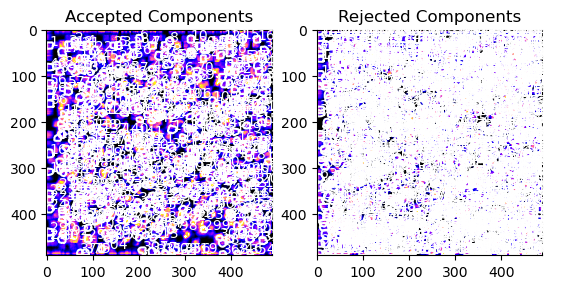

In [78]:
plt.figure(figsize=(20,10))
#ests.plot_contours(img=np.asarray(metrics['mean_image']),idx=ests.idx_components,cmap=plt.cm.gnuplot2)
ests.plot_contours(idx=ests.idx_components,cmap=plt.cm.gnuplot2)

# Visualize sparated sources

In [30]:
ests = cnmf.estimates
#call plotting function to compute contours
ests.plot_contours(idx=ests.idx_components,cmap=plt.cm.gnuplot2)
plt.close()

mcorr_movie = cm.load(mmap_file)

Decode mmap filename /scratch/dspalla/2p_data/429420_toms/20230211_no_equalization/cropped_20230211_429420_00001_els__d1_490_d2_490_d3_1_order_F_frames_90724.mmap


In [31]:
# make an image widget
iw = ImageWidget(
    mcorr_movie, 
    window_funcs={"t": (np.mean, 100)},
    vmin_vmax_sliders=True,
    cmap="gnuplot2"
)



iw.show()


RFBOutputContext()

In [197]:
snr_th = 3
cnn_th = 0.9
r_th = 0.9

good_components = np.where(np.logical_and(ests.SNR_comp>snr_th,ests.cnn_preds>cnn_th,ests.r_values>r_th))[0]
print(len(good_components))
contours = [ests.coordinates[i]['coordinates'] for i in ests.idx_components]
iw.plot.add_line_collection(contours, colors="w", alpha=0.7)

196


LineCollection @ 0x14ba070ea440
Collection of <266> Graphics

In [140]:
iw.plot.canvas.close()

# ROC

Text(0.5, 0, 'cnn confidence')

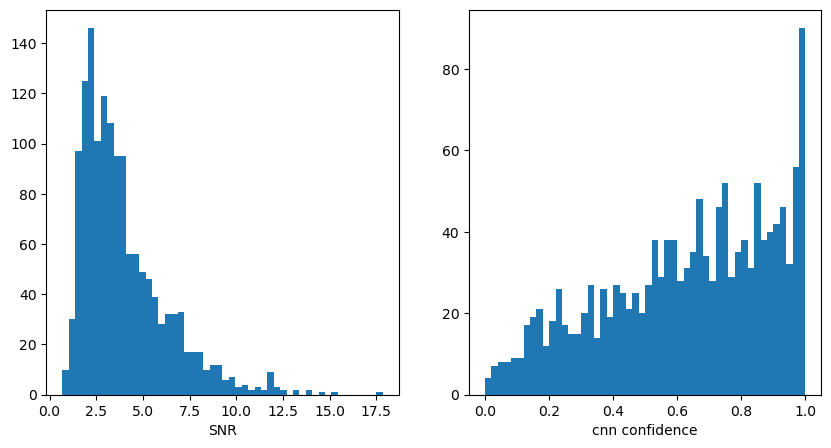

In [198]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(ests.SNR_comp,bins=50);
plt.xlabel('SNR')
plt.subplot(1,2,2)
plt.hist(ests.cnn_preds,bins=50);
plt.xlabel('cnn confidence')

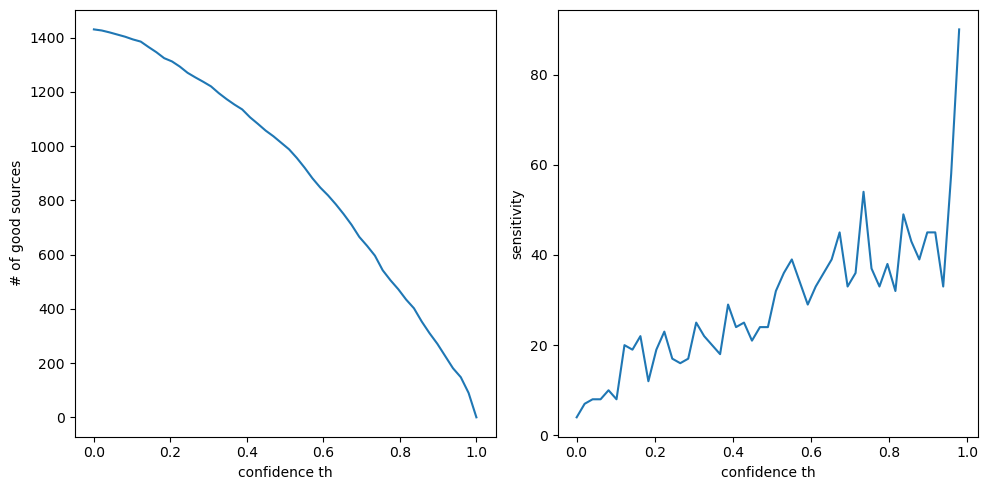

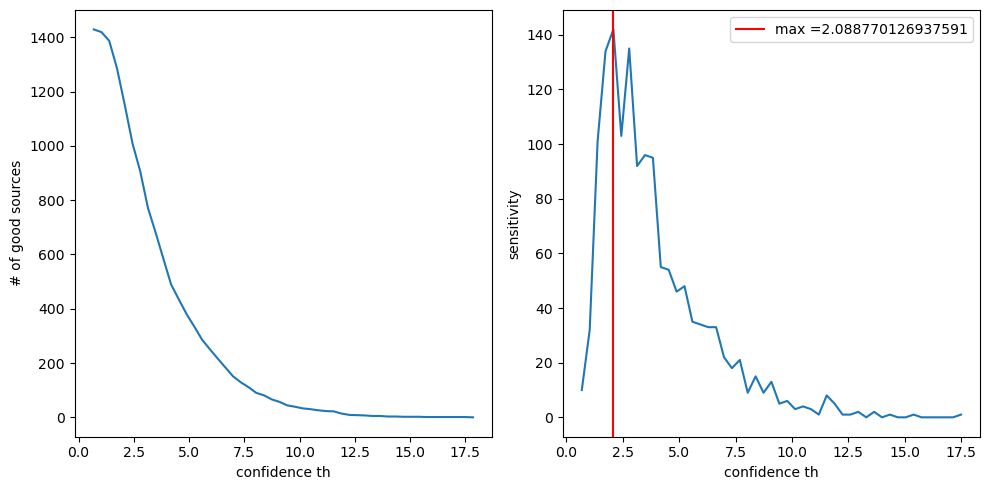

In [199]:
ths_cnn = np.linspace(0,1)
ths_snr = np.linspace(min(ests.SNR_comp),max(ests.SNR_comp))


good_sources_cnn = []
good_sources_snr = []

for th_cnn,th_snr in zip(ths_cnn,ths_snr):
    good_sources_cnn.append(np.sum(ests.cnn_preds>th_cnn))
    good_sources_snr.append(np.sum(ests.SNR_comp>th_snr))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(ths_cnn,good_sources_cnn)
plt.xlabel('confidence th')
plt.ylabel('# of good sources')
plt.subplot(1,2,2)
plt.plot(ths_cnn[:-1],abs(np.diff(good_sources_cnn)))
plt.xlabel('confidence th')
plt.ylabel('sensitivity')
plt.tight_layout()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(ths_snr,good_sources_snr)
plt.xlabel('confidence th')
plt.ylabel('# of good sources')
plt.subplot(1,2,2)
plt.plot(ths_snr[:-1],abs(np.diff(good_sources_snr)))
max_sens = ths_snr[np.argmax(abs(np.diff(good_sources_snr)))]
plt.axvline(x=max_sens,label=f'max ={max_sens}',c='r')
plt.legend()
plt.xlabel('confidence th')
plt.ylabel('sensitivity')
plt.tight_layout()

In [ ]:
neural_data.keys()

# Plot unit footprints and timecourse

In [200]:
from ipywidgets import interact
import ipywidgets as widgets

def plot_unit(i,min_time,max_time):
    
    good_traces = ests.C[ests.idx_components]
    good_footprints = ests.A[:,ests.idx_components].toarray()

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.title(f'neuron {i}')
    plt.imshow(good_footprints[:,i].reshape(ests.dims),cmap=plt.cm.gnuplot2)
    
    plt.subplot(1,2,2)
    plt.plot(np.arange(min_time,max_time),good_traces[i,min_time:max_time])
    
    
    plt.tight_layout()
    
    
    
interact(plot_unit, i = widgets.IntSlider(min=0, max=(len(ests.idx_components)-1), value=0),
                    min_time =widgets.IntSlider(min=0, max=ests.C.shape[1]-1, value=0),
                    max_time = widgets.IntSlider(min=0, max=ests.C.shape[1]-1, value=10000)
         )

interactive(children=(IntSlider(value=0, description='i', max=265), IntSlider(value=0, description='min_time',…

<function __main__.plot_unit(i, min_time, max_time)>

# Recondstructed video

In [10]:
# memory intensive
movie_len = 10000
r_mov = ests.A[:,ests.idx_components]@ests.C[ests.idx_components,:movie_len]


In [13]:
r_mov = r_mov.reshape(ests.dims[0],ests.dims[1],movie_len)
r_mov = np.transpose(r_mov,(2,0,1))

In [14]:
r_mov.shape

(10000, 490, 490)

In [15]:
# make an image widget
from fastplotlib import ImageWidget, Plot, GridPlot
from ipywidgets import VBox, IntSlider, Layout

iw = ImageWidget(
    r_mov, 
    window_funcs={"t": (np.mean, 10)},
    vmin_vmax_sliders=True,
    cmap="gnuplot2"
)



iw.show()

RFBOutputContext()

<Figure size 1000x500 with 0 Axes>

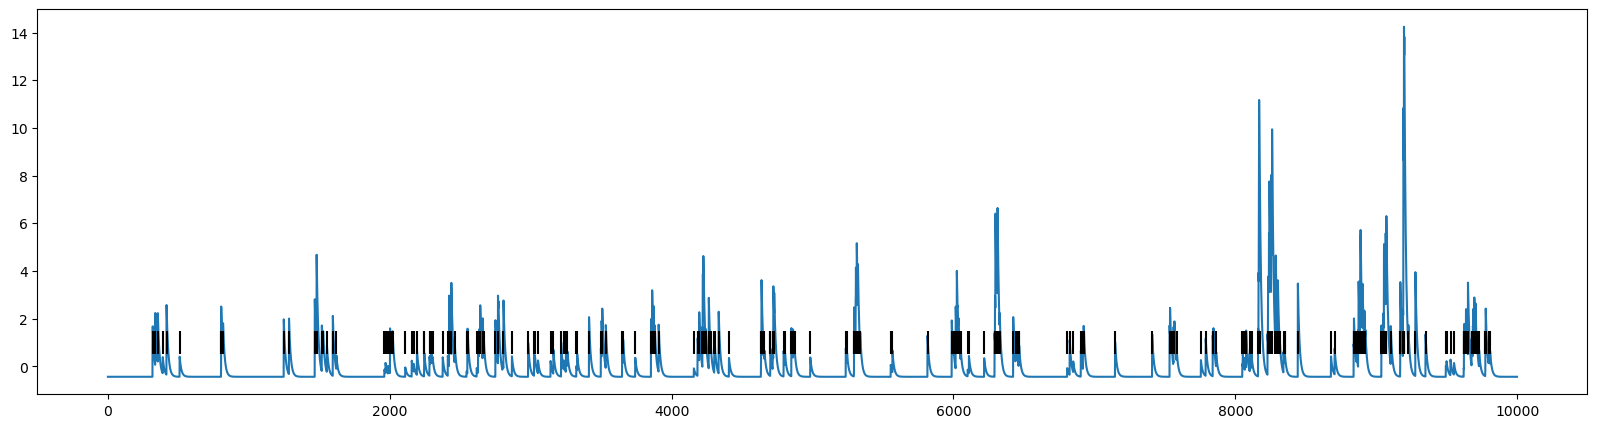

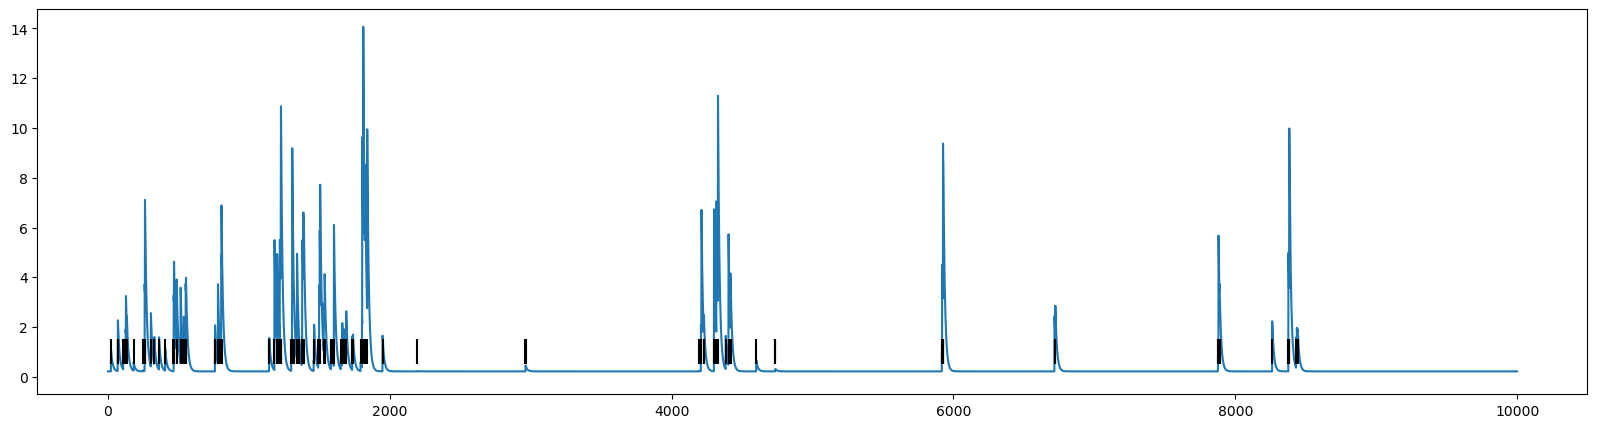

In [115]:
from scipy.stats import zscore
plt.figure(figsize=(10,5))
zstep=0.5

for i in range(2):
    plt.figure(figsize=(20,5))
    trace = neural_data['traces'][i,:10000]
    trace = zscore(trace)
    plt.plot(trace+i*zstep)
    
    spikes = np.where(neural_data['deconvolved'][i,:10000]>0)[0]
    
    plt.eventplot(spikes,color='k')

In [51]:
save_path = data_path.joinpath('neural_data.npy')
filehandler = open(save_path, 'wb') 
pickle.dump(neural_data, filehandler)
filehandler.close()

In [31]:
c = {'x':1,'y':2}
a = {'a':1,'b':c}

In [37]:
with open('prova.yml','w') as file:
    yaml.dump(a,file)

In [36]:
coms = np.asarray([i['CoM'] for i in ests.coordinates])[ests.idx_components]

In [45]:
len(ests.coordinates)

627

In [41]:
import pickle

In [44]:
data_path = Path("/ceph/imaging1/davide/2p_data/429420_toms/20230210")
filehandler = open(data_path.joinpath('neural_data.pickle'), 'rb')
neural_data = pickle.load(filehandler)
filehandler.close()

In [88]:
neural_data.keys()

dict_keys(['traces', 'footprints', 'df_f', 'deconvolved', 'positions', 'contour'])

In [90]:
traces = neural_data['traces']
spikes = neural_data['deconvolved']
positions = neural_data['positions']

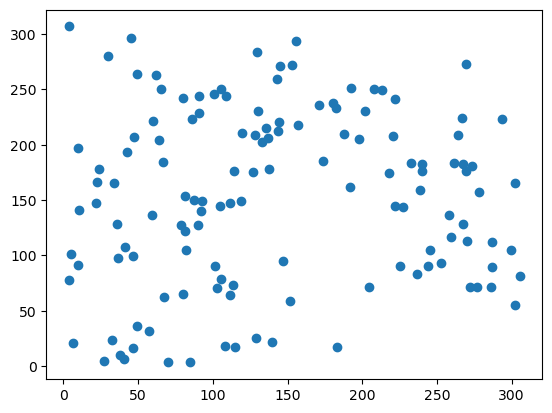

In [95]:
plt.scatter(positions[:,1],positions[:,0])

(-1.0, 5.0)

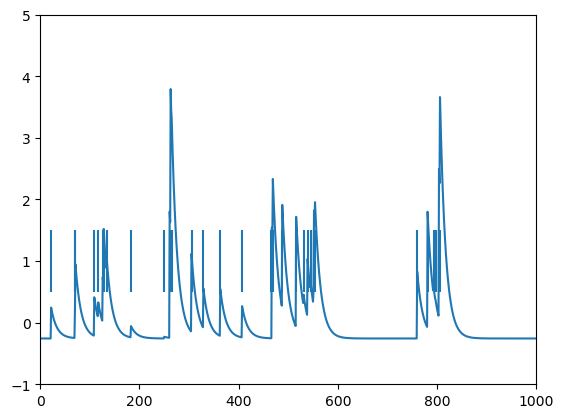

In [86]:
import matplotlib.pyplot as plt
from scipy.stats import zscore

neuron = 1
plt.plot(zscore(traces[neuron]))
plt.eventplot(spikes[neuron])
plt.xlim([0,1000])
plt.ylim([-1,5])

In [69]:
import numpy as np

In [73]:
np.corrcoef(traces[0],traces[1])[0,1]

0.022051987341533755